# 0. Import Related Pakage 

In [1]:
# basic
import pandas as pd
import os
import numpy as np
import sklearn.metrics
import matplotlib.pyplot as plt

# data transformation onehot encode
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# machine learning training
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

#  1. Data
## 1.1 Import Clean Data

In [2]:
url = 'https://raw.githubusercontent.com/MengSui0218/CS668-2021-MS/main/Data/clean_data.csv'
df = pd.read_csv(url)
df = df.drop(['Unnamed: 0'], axis =1 )
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,0,No Deposit,304.0,0,Transient,75.0,0,0,Check-Out,2015-07-02
1,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,0,No Deposit,240.0,0,Transient,98.0,0,1,Check-Out,2015-07-03
2,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,0,No Deposit,240.0,0,Transient,98.0,0,1,Check-Out,2015-07-03
3,Resort Hotel,0,9,2015,July,27,1,0,2,2,...,0,No Deposit,303.0,0,Transient,103.0,0,1,Check-Out,2015-07-03
4,Resort Hotel,1,85,2015,July,27,1,0,3,2,...,0,No Deposit,240.0,0,Transient,82.0,0,1,Canceled,2015-05-06


## 1.2 Drop Null Records and Columns 

In [3]:
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

1. based on EDA, cancellation from years to years keeps the same level, but it dose vary in different month. Thus, in ML process, column arrival_date_year will be dropped. 
2. column related to after check-in are supposed to be dropped, such as *assigned_room_type*, *reservation_status*, 

In [4]:
# drop columns that post related 
df_ml = df.drop(['arrival_date_year','reservation_status','reservation_status_date','assigned_room_type'],axis=1)

# slice data to independent attributes and predicted columns
x, y = df_ml.drop(['is_canceled'], axis= 1), df_ml['is_canceled']


In [5]:
# check independent attributes 
x.columns

Index(['hotel', 'lead_time', 'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'booking_changes', 'deposit_type', 'agent', 'days_in_waiting_list',
       'customer_type', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests'],
      dtype='object')

# 2. Organize training steps 

## explaining onehot encoder
In this project, there are a few category atributes that can not be numeriazed by related machine learning algorithms. Thus transdering them to number is necessery for them before applying machine learning algorithms. 
When trasfering string type to number type, using sequenced number to present a series of category string is common transformantion. But issues can arise when original categories are norminal. Simply using number to reprent norminal data will mistakely assump that categories has order and different impact level on final prediciton. Thus, we used onehot encoder to transform category data. 
OneHot Encoder adds new coresponding columns to present categories, and use "0" and "1" to present observations belongs to these categories. 

In [6]:
# set up onehot encode category transformation pipeline
str_transformer = Pipeline(steps= [('onehot',OneHotEncoder(handle_unknown = 'ignore'))])
str_col = ['hotel','arrival_date_month','meal','country','market_segment','distribution_channel','deposit_type','customer_type']
preprocesser = ColumnTransformer(transformers= [('Str',str_transformer, str_col)])

## 2.1 Try out different algorithms 
Try out different algorithms at the same time to select out the algorithm that has the highest prediction accuracy even based on defaut parameters. It is efficient to select the best suitable machine learning algorithms.

In [8]:
# set up shuffting for 10 folded cross validation
kfolds = 10 
split = KFold(n_splits = kfolds, shuffle = True, random_state=42)

# build up model matrix
base_model = [('dt',DecisionTreeClassifier(random_state=42)),
              ('rf', RandomForestClassifier(random_state=42)),
              #('SVM',SVC(gamma='auto')),
              ('lgr', LogisticRegression(solver='lbfgs', max_iter=1000,random_state=42)),
              #('NB',GaussianNB(priors=2)),
              ('KNN',KNeighborsClassifier(n_neighbors=3))]

# create list to save all accuracy rate for every model
res = []
alg_name = []

# try out machine learning algorithms with 10 folded cross validation
for name, model in base_model:
  model_steps = Pipeline(steps = [('preprocesser', preprocesser),
                                  ('model', model)])
  
  cv_result = cross_val_score(model_steps,
                              x,y,
                              cv = split,
                              scoring = 'accuracy')
  res.append(cv_result)
  alg_name.append(name)

  # minimum accuracy 
  min_score = round(min(cv_result),4)
  # maximum accuracy 
  max_score = round(max(cv_result),4)
  # average of accuracy 
  mean_score = round(np.mean(cv_result),4)
  # standard diviation of accuracy 
  std = round(np.std(cv_result),4)
  
  print(f'{name} cross validation score: {mean_score}+/-{std}, min: {min_score}, max: {max_score}')

dt cross validation score: 0.7682+/-0.0036, min: 0.7642, max: 0.777
rf cross validation score: 0.7684+/-0.0038, min: 0.7635, max: 0.7776
lgr cross validation score: 0.7345+/-0.0034, min: 0.7279, max: 0.7401
KNN cross validation score: 0.6647+/-0.004, min: 0.6569, max: 0.6698


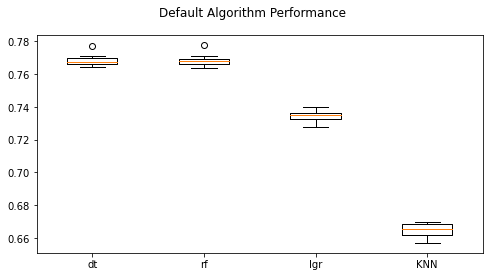

In [19]:
# plot model prediction accuracy 
fig = plt.figure(figsize = (8,4))
fig.suptitle('Default Algorithm Performance')
ax = fig.add_subplot(111)
plt.boxplot(res)
ax.set_xticklabels(alg_name)
plt.show()

Thus, Decision Tree and Linear Regression have the top 2 accuracy rate. For next step, we fine-tuned the model by adjusting cerntain paramters to get higher prediction rate. 

## 2.2 Fine Tune the model 
1. 64% data is used to training model 
2. 33% data is used to test

In [10]:
# import related muduel
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import numpy as np
import joblib

In [11]:
#split training dataset and testing dataset
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.34, random_state=42)

In [14]:
# set parameter matrix for algorithms 
tune_model = [('dt',DecisionTreeClassifier(random_state=42), 
                {'model__criterion': ("gini","entropy"), 
                'model__max_depth': range(1,15),
                'model__max_features' : ("auto","sqrt", "log2"),
                'model__splitter' : ("best", "random"),
                }),
              ('rf', RandomForestClassifier(random_state=42),
                #{'model__n_estimators': range(100,150),
                {'model__criterion': ("gini", "entropy"),
                'model__max_features': ("auto", "log2"),
                }),
              ]
# create list to store training results 
opt_res = []
opt_alg_name = []

In [15]:
# set up training pipeline 
path = f"/Users/suimeng/Desktop/IS688/CS668_Project/CS668-2021-MS/best_estimator"

for name, model, parameter in tune_model:
    # pipeline, transform category data to numrical data
    model_steps = Pipeline(steps = [('preprocesser', preprocesser),
                                  ('model', model)])
    clf = GridSearchCV(
            estimator = model_steps, 
            param_grid = parameter, 
            cv = 10,
            scoring='accuracy'
        )

    #clf.fit(x_train, y_train)
    #! training on the whole dataset 
    clf.fit(x, y)

    # save cross validation score
    opt_res.append(clf.scorer_)
    opt_alg_name.append(name)

    # save the best estimator 
    joblib.dump(clf.best_estimator_, f'{path}/best_estimator_{name}.pkl')
    print(clf.scorer_)

    print(f"Best parameters for {name}:")
    print(f'{clf.best_params_} \n')
    print(f'Grid scores on development set:')
    #means = np.mean(clf.cv_results_['mean_test_score'])
    #stds = np.std(clf.cv_results_['std_test_score'])
    print(f'the higest accuracy rate cane be reached at {clf.best_score_} \n' )

make_scorer(accuracy_score)
Best parameters for dt:
{'model__criterion': 'entropy', 'model__max_depth': 5, 'model__max_features': 'auto', 'model__splitter': 'random'} 

Grid scores on development set:
the higest accuracy rate cane be reached at 0.7139013349949341 

make_scorer(accuracy_score)
Best parameters for rf:
{'model__criterion': 'gini', 'model__max_features': 'log2'} 

Grid scores on development set:
the higest accuracy rate cane be reached at 0.5572894278575597 



## 2.3 Redo training process with best estimators

In [16]:
# redo model Decision Tree
dt = DecisionTreeClassifier(criterion='entropy', 
                            random_state=42, 
                            max_depth = 5,
                            max_features = 'auto',
                            splitter = 'random',
                            )

# kfolds = 15
# split = KFold(n_splits = kfolds, shuffle = True, random_state=42)

model_steps = Pipeline(steps = [('preprocesser', preprocesser),
                                  ('model', dt)])

cv_result = cross_val_score(model_steps,
                              x,y,
                              cv = 10,
                              scoring = 'accuracy')

# minimum accuracy 
min_score = round(min(cv_result),4)
# maximum accuracy 
max_score = round(max(cv_result),4)
# average of accuracy 
mean_score = round(np.mean(cv_result),4)
# standard diviation of accuracy 
std = round(np.std(cv_result),4)

print(f'decision tree best estimator cross validation score: {mean_score}+/-{std}, min: {min_score}, max: {max_score}')
                            

decision tree best estimator cross validation score: 0.7139+/-0.0526, min: 0.651, max: 0.8383


In [18]:
# redo model Random Forest
rf = RandomForestClassifier(random_state=42,
                            criterion = 'gini',
                            max_features = 'log2'
                            )

# kfolds = 15
# split = KFold(n_splits = kfolds, shuffle = True, random_state=42)

model_steps = Pipeline(steps = [('preprocesser', preprocesser),
                                  ('model', rf)])

cv_result = cross_val_score(model_steps,
                              x,y,
                              cv = 10,
                              scoring = 'accuracy')

# minimum accuracy 
min_score = round(min(cv_result),4)
# maximum accuracy 
max_score = round(max(cv_result),4)
# average of accuracy 
mean_score = round(np.mean(cv_result),4)
# standard diviation of accuracy 
std = round(np.std(cv_result),4)

print(f'decision tree best estimator cross validation score: {mean_score}+/-{std}, min: {min_score}, max: {max_score}')

decision tree best estimator cross validation score: 0.5573+/-0.0913, min: 0.3929, max: 0.6619
